In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error


from collections import Counter
import re
import string

In [2]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NODES = 1000

In [42]:
df = pd.read_csv("../uci_data/OnlineNewsPopularity_extended.csv")
print("calculating mean/median")
mean =  df["shares"].mean()
median = df["shares"].median()
print("mean: ", mean)
print("median: ", median)
[print(len(df))]

calculating mean/median
mean:  3395.3801836343455
median:  1400.0
39644


[None]

In [43]:
df.loc[df['shares'] < median, 'shares'] = 0
df.loc[df['shares'] >= median, 'shares'] = 1
df = df.iloc[:, 2:]

In [44]:
df['content'] = df['content'].fillna('')
df['content_length'] = df['content'].apply(lambda x: len(x.split()))

In [45]:
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,title,content,label_by_mean,label_by_median,content_length
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.500000,-0.187500,0.000000,0.187500,0,Amazons Streaming Video Library Now a Little E...,Having trouble finding something to watch on A...,1,1,210
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,APs Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,1,1,250
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,1,Apples App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,1,0,197
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,0,This Astronaut Is Rooting for Notre Dame Tonight,When it comes to college football NASA astrona...,1,1,478
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.454545,0.136364,0.045455,0.136364,0,New UVerse Apps Simplify Sharing Photos and Vi...,LAS VEGAS — Sharing photos and videos on your ...,1,1,289


In [47]:
# mean content length

np.mean(df['content_length'])

404.07882655635154

In [48]:
#tokenization
tok = spacy.load('en')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [49]:
#count number of occurences of each word
counts = Counter()
for index, row in df.iterrows():
    counts.update(tokenize(row['content']))

In [50]:
#deleting infrequnet words
print("num_words before:", len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 202157
num_words after: 102822


In [51]:
# creating vocab
vocab2index = {"":0, "UNK":1}
words = ["","UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [52]:
def encode_sentence(text, vocab2index, N=450):
    tokenized = tokenize(text)
    encoded = np.zeros(N,dtype=int)
    enc1 = np.array([vocab2index.get(word,vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [53]:
df['encoded'] = df['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,title,content,label_by_mean,label_by_median,content_length,encoded
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,-0.187500,0.000000,0.187500,0,Amazons Streaming Video Library Now a Little E...,Having trouble finding something to watch on A...,1,1,210,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.500000,0.000000,0,APs Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,1,1,250,"[[12, 145, 146, 98, 12, 99, 147, 85, 6, 148, 9..."
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.500000,0.000000,1,Apples App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,1,0,197,"[[81, 263, 264, 265, 139, 100, 78, 237, 140, 6..."
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.500000,0.000000,0,This Astronaut Is Rooting for Notre Dame Tonight,When it comes to college football NASA astrona...,1,1,478,"[[336, 81, 337, 6, 338, 339, 340, 341, 342, 34..."
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.136364,0.045455,0.136364,0,New UVerse Apps Simplify Sharing Photos and Vi...,LAS VEGAS — Sharing photos and videos on your ...,1,1,289,"[[171, 172, 122, 525, 519, 25, 66, 8, 526, 26,..."


In [5]:
df.head()
len(df.columns)

59

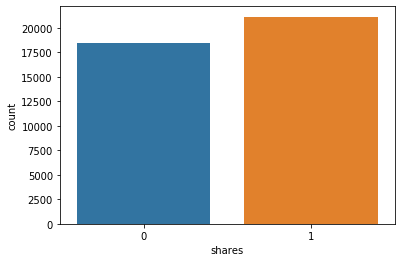

In [55]:
sns.countplot(x = 'shares', data=df)

In [7]:
#X = df.iloc[:, 0:-1]
#y = df.iloc[:, -1]

In [8]:
X

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,...,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,...,0.374825,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000
39641,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,5.076923,...,0.307273,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364
39642,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,4.975073,...,0.236851,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000


In [9]:
y


0        0
1        0
2        1
3        0
4        0
        ..
39639    1
39640    1
39641    1
39642    0
39643    0
Name:  shares, Length: 39644, dtype: int64

In [81]:
X = list(df['encoded'])
y = list(df['shares'])

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=69)

In [83]:
class NewsDataset(Dataset):
    def __init__(self, X, Y):
            self.X = X
            self.y = Y
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [84]:
train_ds = NewsDataset(X_train, y_train)
valid_ds = NewsDataset(X_valid, y_valid)

In [140]:
def train_model(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    for i in range(EPOCHS):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() *y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i%5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [141]:
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [142]:
class LSTM_fixed_len(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [143]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [144]:
model_fixed = LSTM_fixed_len(vocab_size, 50, 50)
model_fixed

LSTM_fixed_len(
  (embeddings): Embedding(102824, 50, padding_idx=0)
  (lstm): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [145]:
train_model(model_fixed)  

train loss 0.691, val loss 0.690, val accuracy 0.540, and val rmse 0.678
train loss 0.690, val loss 0.690, val accuracy 0.538, and val rmse 0.680
train loss 0.687, val loss 0.691, val accuracy 0.537, and val rmse 0.680
train loss 0.683, val loss 0.693, val accuracy 0.536, and val rmse 0.681
train loss 0.674, val loss 0.699, val accuracy 0.535, and val rmse 0.682
train loss 0.662, val loss 0.710, val accuracy 0.534, and val rmse 0.683
train loss 0.645, val loss 0.725, val accuracy 0.533, and val rmse 0.683
train loss 0.625, val loss 0.751, val accuracy 0.533, and val rmse 0.683
train loss 0.608, val loss 0.770, val accuracy 0.531, and val rmse 0.685
train loss 0.594, val loss 0.793, val accuracy 0.532, and val rmse 0.684
train loss 0.580, val loss 0.816, val accuracy 0.532, and val rmse 0.684
train loss 0.565, val loss 0.851, val accuracy 0.532, and val rmse 0.684
train loss 0.553, val loss 0.875, val accuracy 0.530, and val rmse 0.685
train loss 0.543, val loss 0.906, val accuracy 0.52

KeyboardInterrupt: 

In [46]:
## train data  
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [80]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [81]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 58.
        self.layer_1 = nn.Linear(58, NODES) 
        self.layer_2 = nn.Linear(NODES, NODES)
        self.layer_3 = nn.Linear(NODES, NODES)
        self.layer_4= nn.Linear(NODES, NODES)
        self.layer_out = nn.Linear(NODES, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(NODES)
        self.batchnorm2 = nn.BatchNorm1d(NODES)
        self.batchnorm3 = nn.BatchNorm1d(NODES)
        self.batchnorm4 = nn.BatchNorm1d(NODES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [83]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=58, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_4): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_out): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [84]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [85]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.66039 | Acc: 63.279
Epoch 002: | Loss: 0.61167 | Acc: 66.606
Epoch 003: | Loss: 0.60290 | Acc: 67.587
Epoch 004: | Loss: 0.59184 | Acc: 68.067
Epoch 005: | Loss: 0.58322 | Acc: 68.913
Epoch 006: | Loss: 0.57233 | Acc: 69.635
Epoch 007: | Loss: 0.55725 | Acc: 70.962
Epoch 008: | Loss: 0.54488 | Acc: 71.625
Epoch 009: | Loss: 0.52243 | Acc: 73.356
Epoch 010: | Loss: 0.50960 | Acc: 74.135
Epoch 011: | Loss: 0.48391 | Acc: 75.981
Epoch 012: | Loss: 0.45588 | Acc: 77.769
Epoch 013: | Loss: 0.42766 | Acc: 79.279
Epoch 014: | Loss: 0.39070 | Acc: 81.548
Epoch 015: | Loss: 0.35392 | Acc: 83.558
Epoch 016: | Loss: 0.30813 | Acc: 86.106
Epoch 017: | Loss: 0.27973 | Acc: 87.606
Epoch 018: | Loss: 0.25027 | Acc: 89.058
Epoch 019: | Loss: 0.21046 | Acc: 91.000
Epoch 020: | Loss: 0.19261 | Acc: 91.904
Epoch 021: | Loss: 0.16147 | Acc: 93.337
Epoch 022: | Loss: 0.14403 | Acc: 94.144
Epoch 023: | Loss: 0.12276 | Acc: 94.885
Epoch 024: | Loss: 0.11840 | Acc: 95.212
Epoch 025: | Los

In [86]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [87]:
confusion_matrix(y_test, y_pred_list)


array([[3468, 2539],
       [2594, 4482]], dtype=int64)

In [88]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.57      0.58      0.57      6007
           1       0.64      0.63      0.64      7076

    accuracy                           0.61     13083
   macro avg       0.61      0.61      0.61     13083
weighted avg       0.61      0.61      0.61     13083

